In [24]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [25]:
n_epochs=3
batch_size_train=64
batch_size_test=1000
learning_rate=0.01
momentum=0.5
log_interval=10
random_seed=1
torch.backends.cudnn.enabled=False
torch.manual_seed(random_seed)

In [26]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/Applications/ML Cornell/PREC',
                               train=True,
                               download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
                                   batch_size=batch_size_train,
                                   shuffle=True)

In [27]:
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        '/Applications/ML Cornell/PREC/',
        train=False,
        download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307),(0.3081))
        ])),
    batch_size=batch_size_test,
    shuffle=True
)

In [28]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
"""
organizes test data in batches
enumerate(test_loader): This turns the test data into a list where each batch has a number (index) attached to it.
next(examples): This gets the first batch from the list of batches in examples
batch_idx: The number (index) of the current batch.
example_data: The actual test data in the batch (e.g., images).
example_targets: The correct labels for the test data in the batch (e.g., digit classes).
"""
example_data.shape

torch.Size([1000, 1, 28, 28])

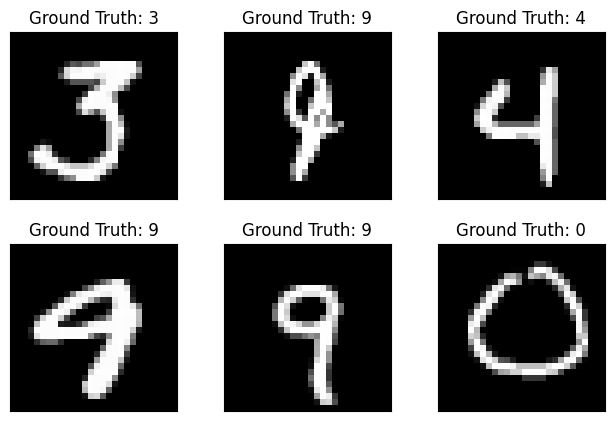

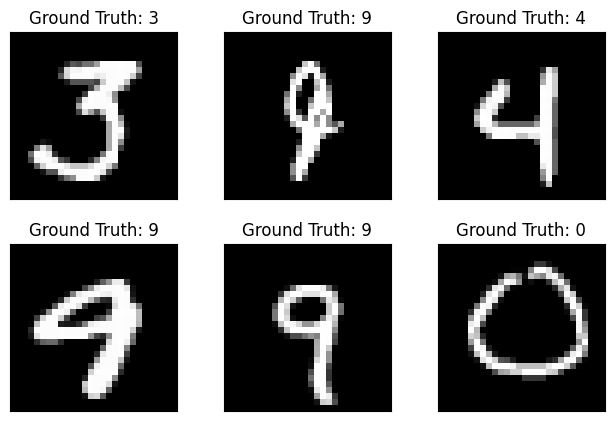

In [29]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [30]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [31]:
#create neural network
#convolutional layer
#pooling layer
#fully connected layer
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    #first layer: convolutional layer
      #conv1 creates a 2d conv layer with 1 input channel, 10 output channels (filters), and 5x5 kernel size
    self.conv1 = nn.Conv2d(1,10,kernel_size=5)
      #conv2 creates a conv layer with 10 input channels, 20 output channels, and a 5x5 kernel
    self.conv2 = nn.Conv2d(10,20,kernel_size=5)
    #pooling layer, creates a max pool layer with 2x2 window
    self.maxpool = nn.MaxPool2d(2)
    #activation function
    self.relu = nn.ReLU()
    #fully connected layer
      #fully connected layer with 320 input features and 50 output features
    self.fc1 = nn.Linear(320,50)
      #fully connected layer with 50 input features and 10 output features
    self.fc2 = nn.Linear(50,10)
    self.softmax = nn.LogSoftmax()

  #feedforward network
  def forward(self,x):
    x = self.relu(self.conv1(x))
    x = self.maxpool(x)
    x = self.relu(self.conv2(x))
    x = self.maxpool(x)
    x = x.view(-1,320) #flattens the tensor to a shape of [batch_size,320] to prepare it for FC layer
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.softmax(x)
    return x



In [32]:
#initialize the neural network class Net() and move to nvidia GPU
network = Net().to('cuda')
#call the stochastic gradient descent function SGD
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#Defines the loss function (negative log-likelihood loss) that will be used to evaluate how well the network's predictions match the target values.
nllloss = nn.NLLLoss()

In [33]:
train_losses = []
train_counter = []
test_losses = []
#test counter holds the values indicating the number of training examples processed at diff points in training
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs+1)]

In [34]:
def train(epoch):
  network.train()
  #iterates over train_loader -- has batches of training data and corresponding targets
  for batch_idx, (data,target) in enumerate(train_loader):
    # data is the input data for the current batch
    data = data.to('cuda')
    # target is the target labels for the current batch
    target = target.to('cuda')
    # resets the gradients of the model parameters
    # gradients are accum by default in pytorch so must be zeroed
    optimizer.zero_grad()
    # computes the network's output
    output = network(data)
    # calculates the loss between network's output and target labels
    loss = nllloss(output,target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval==0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      train_losses.append(loss.item())
      train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [36]:
def test():
  #puts network in evaluation mode
  network.eval()
  # test loss accumulates the total loss over the test set
  test_loss = 0
  # counts the number of correct predictions
  correct = 0
  # disables gradient calculation and speeds up computation
  with torch.no_grad():
    #iterate over batches of test data
    for data, target in test_loader:
      data = data.to('cuda')
      target = target.to('cuda')
      output = network(data)
      #calculates loss between the network's output and target labels
      test_loss += F.nll_loss(output,target,size_average=False).item()
      #finds the index of the max value in output tensor along dimension 1 - correspodns to predicted class
      pred = output.data.max(1,keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('Accuracy: ',correct.item()/len(test_loader.dataset))

test()
for epoch in range(1,n_epochs+1):
  train(epoch)
  test()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Accuracy:  0.0924
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294923
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.274000
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.260731
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.220409
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.181988
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.080039
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.938053
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.690072
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.548418
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.100647
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.976645
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.688212
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.660203
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.734668
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.534860
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.473771
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.562370
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.491707
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.312373
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.572907
Train Epoch

<ipython-input-37-ad4e3de3dd04>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


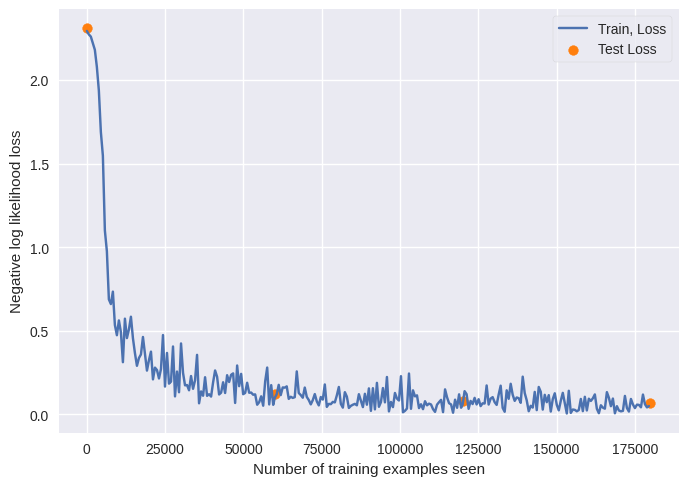

In [37]:
plt.style.use('seaborn')
plt.plot(train_counter, train_losses)
plt.scatter(test_counter, test_losses, color='tab:orange')
plt.legend(['Train, Loss', 'Test Loss'],  frameon=True)
plt.xlabel('Number of training examples seen')
plt.ylabel('Negative log likelihood loss')
plt.show()

In [38]:
test()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Accuracy:  0.9787
